In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

# set filepath to data source
filepath = "games.csv"


In [2]:
# load data into dataframe
games_df = pd.read_csv(filepath)
games_df.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


In [3]:
# make bins for player rating ranges
games_df["white_range"] = pd.cut(games_df["white_rating"], [0] + list(range(1200, 3000, 200)))
games_df["black_range"] = pd.cut(games_df["black_rating"], [0] + list(range(1200, 3000, 200)))

In [4]:
# High ELO_diff implies white should win;  low (negative) values imply black should win
games_df["elo_diff"] = games_df["white_rating"]-games_df["black_rating"]

In [5]:
games_df["elo_diff"].describe()

count    20058.000000
mean         7.799880
std        249.036667
min      -1605.000000
25%       -108.000000
50%          3.000000
75%        122.000000
max       1499.000000
Name: elo_diff, dtype: float64

In [6]:
games_df[(games_df["elo_diff"] < 0)]["elo_diff"].describe()

count    9671.000000
mean     -171.410299
std       176.064503
min     -1605.000000
25%      -238.000000
50%      -114.000000
75%       -46.000000
max        -1.000000
Name: elo_diff, dtype: float64

In [7]:
games_df[(games_df["elo_diff"] > 0)]["elo_diff"].describe()

count    10184.000000
mean       178.138158
std        182.205481
min          1.000000
25%         49.000000
50%        119.500000
75%        249.000000
max       1499.000000
Name: elo_diff, dtype: float64

## A – Flank openings

* White first moves other than 1.e4, 1.d4 (A00–A39)
* 1.d4 without 1...d5, 1...Nf6 or 1...f5: Atypical replies to 1.d4 (A40–A44)
* 1.d4 Nf6 without 2.c4: Atypical replies to 1...Nf6 (A45–A49)
* 1.d4 Nf6 2.c4 without 2...e6 or 2...g6: Atypical Indian defences (A50–A79)
* 1.d4 f5: Dutch Defence (A80–A99)

## B – Semi-Open Games other than the French Defense

* 1.e4 without 1...c5, 1...e6 or 1...e5 (B00–B19)
* 1.e4 c5: Sicilian Defence (B20–B99)

## C – Open Games and the French Defense

* 1.e4 e6: French Defence (C00–C19)
* 1.e4 e5: Open Game (C20–C99)

## D – Closed Games and Semi-Closed Games

* 1.d4 d5: Closed Game (D00–D69)
* 1.d4 Nf6 2.c4 g6 with 3...d5: Grünfeld Defence (D70–D99)

## E – Indian Defenses

* 1.d4 Nf6 2.c4 e6: Indian systems with ...e6 (E00–E59)
* 1.d4 Nf6 2.c4 g6 without 3...d5: Indian systems with ...g6 (except Grünfeld) (E60–E99)

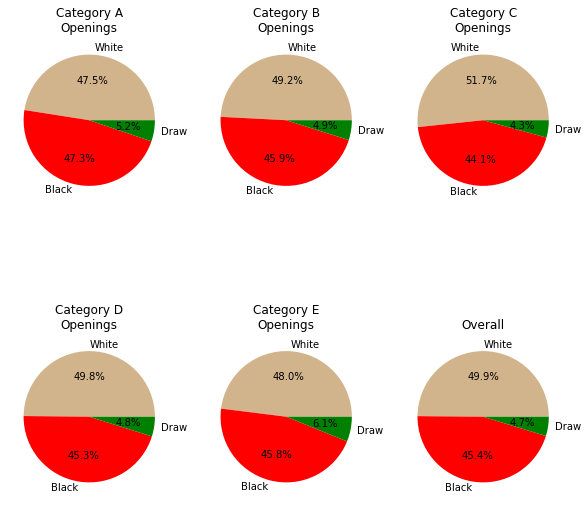

In [8]:
# get general summary data 

## overall wins for white/black
total_wins = games_df["winner"].value_counts()["white"]
total_losses = games_df["winner"].value_counts()["black"]
total_draws = games_df["winner"].value_counts()["draw"]
## counts of openings
openings = games_df["opening_eco"].value_counts()
# get Letter category for opening ECO
games_df["opening_cat"] = games_df["opening_eco"].map(lambda x: x[0])

## graphs to visualize these
fig, axes = plt.subplots(2, 3, figsize = (10,10))
ax1 = axes[1][2]
ax1.pie(x = games_df["winner"].value_counts(), labels = games_df["winner"].value_counts().index.map(str.capitalize), autopct = "%.1f%%", colors = ["tan", "red", "green"])
ax1.set_title("Overall")

for index, value in enumerate(games_df.groupby("opening_cat")["winner"].value_counts().index.get_level_values(0).unique()):
    i = int(index/3)
    j = int(index%3)
    axes[i][j].pie(x = games_df.groupby("opening_cat")["winner"].value_counts()[value], colors = ["tan", "red", "green"], labels = games_df.groupby("opening_cat")["winner"].value_counts()[value].index.map(str.capitalize), autopct = "%.1f%%")
    axes[i][j].set_title(f"Category {value}\nOpenings")

plt.savefig("output/Overall Breakdowns.png")
plt.show()


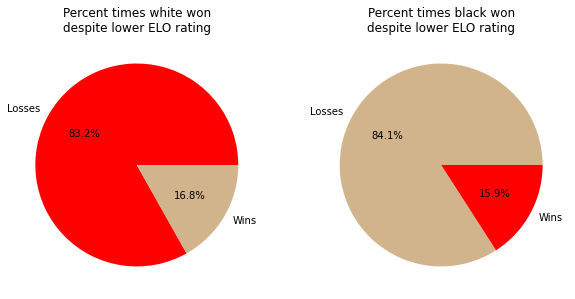

In [9]:
# graph % of times the lower rated player wins per opening per color
white_ud = (games_df["elo_diff"] < 0) & (games_df["winner"] == "white")
black_ud = (games_df["elo_diff"] > 0) & (games_df["winner"] == "black")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,10))

ax1.pie(x = white_ud.value_counts(), labels = white_ud.value_counts().index.map({True : "Wins", False : "Losses"}), autopct = "%.1f%%", colors = ["red", "tan"])
ax1.set_title("Percent times white won\ndespite lower ELO rating")

ax2.pie(x = black_ud.value_counts(), labels = black_ud.value_counts().index.map({True : "Wins", False : "Losses"}), autopct = "%.1f%%", colors = ["tan", "red"])
ax2.set_title("Percent times black won\ndespite lower ELO rating")

plt.savefig("output/Underdog Breakdowns.png")
plt.show()

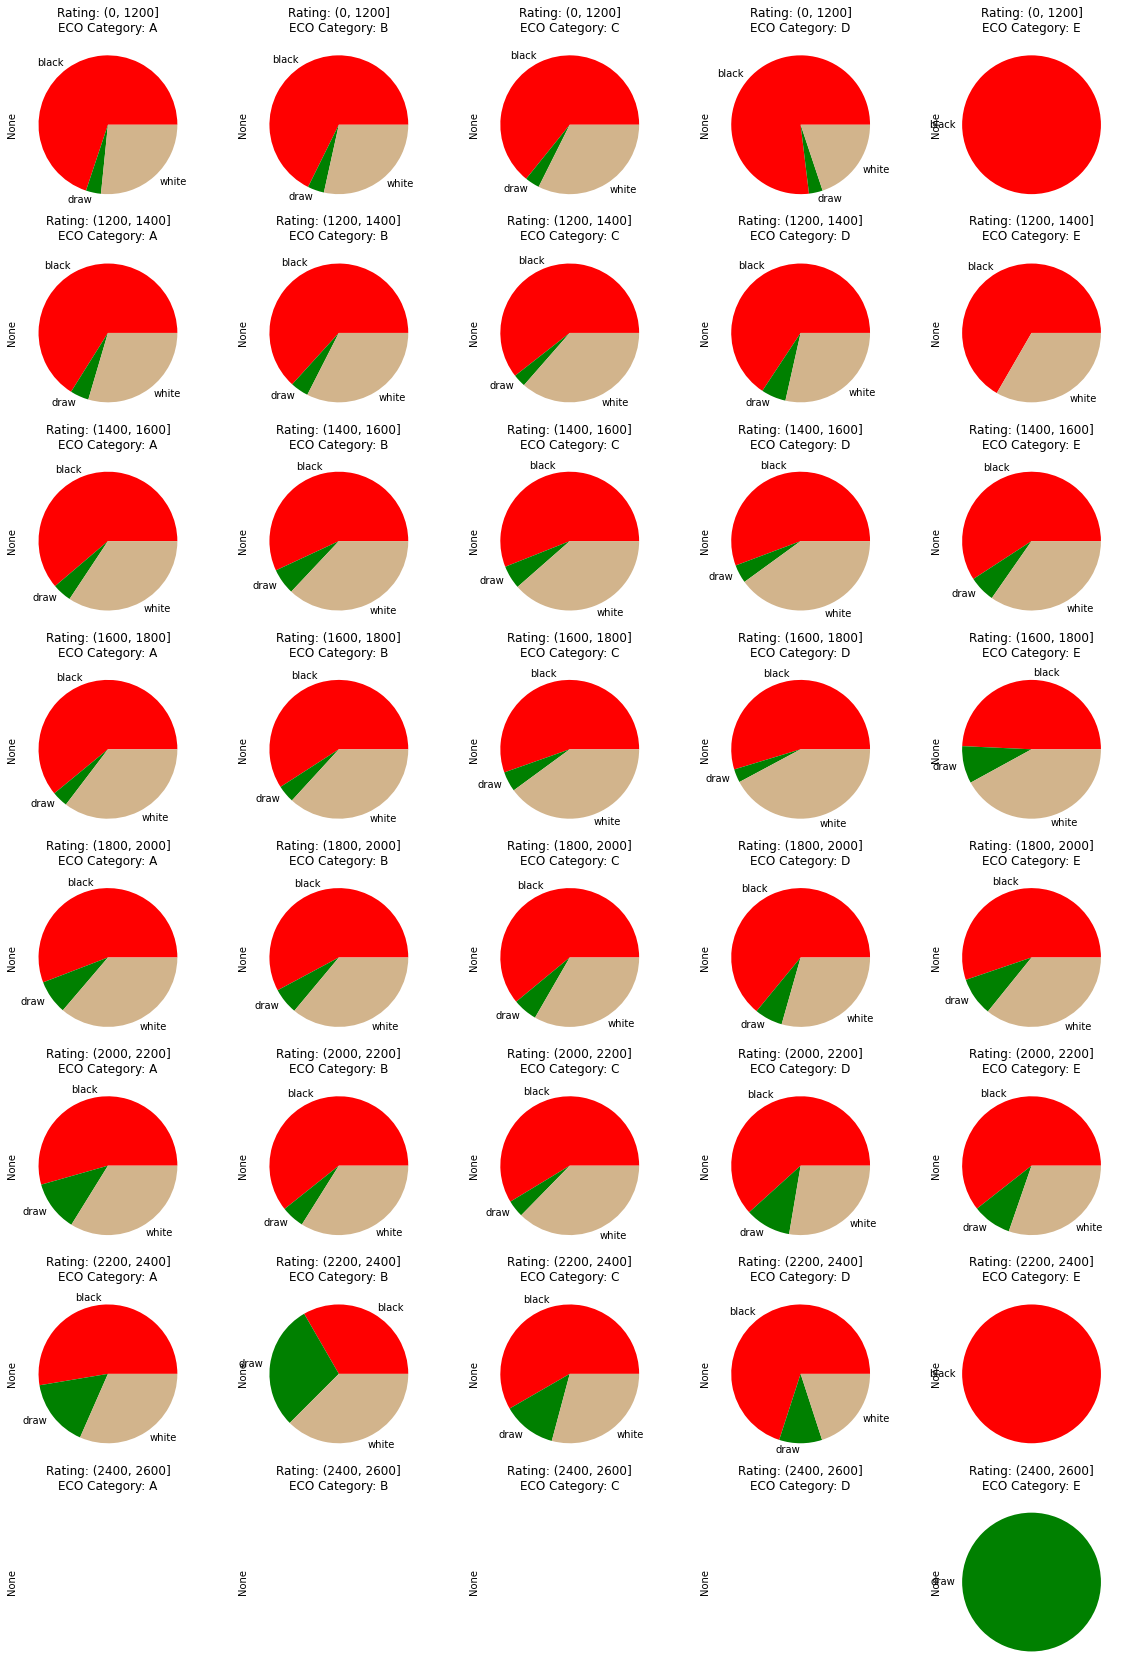

In [10]:
# repeat above work, but with the data binned by ranges of player ratings
wud_by_range = (games_df[(games_df["elo_diff"] < 0)].groupby(["white_range", "opening_cat"])["winner"].value_counts()).rename("winrate")

## graph to visualize this
wud_by_range.reset_index(level = 2).sort_index()

# bud_by_range.unstack(level = 0).plot(kind = "bar", width = 1)

wud_df = wud_by_range.unstack(level = 0).unstack(level = 0).fillna(0).apply(lambda x : 0 if (x.sum() == 0) else (100 * x / float(x.sum())) ).stack(level = 1).reorder_levels([1,0]).sort_index()
wud_df.stack().reorder_levels([2,0,1]).sort_index()

f, a = plt.subplots(len(wud_df.stack().reorder_levels([2,0,1]).sort_index().index.get_level_values(0).unique()), len(wud_df.stack().reorder_levels([2,0,1]).sort_index().index.get_level_values(1).unique()), figsize = (20,30))
for i, elo_range in enumerate(wud_df.stack().reorder_levels([2,0,1]).sort_index().index.get_level_values(0).unique()):
    for j, eco_cat in enumerate(wud_df.stack().reorder_levels([2,0,1]).sort_index()[elo_range].index.get_level_values(0).unique()):
        
        wud_df.stack().reorder_levels([2,0,1]).sort_index()[elo_range][eco_cat].plot(kind = "pie", ax = a[i][j], colors = ["red", "green", "tan"], title = f'Rating: {elo_range}\nECO Category: {eco_cat}')

plt.savefig("output/White Underdog-detailed breakdown.png")
plt.show()

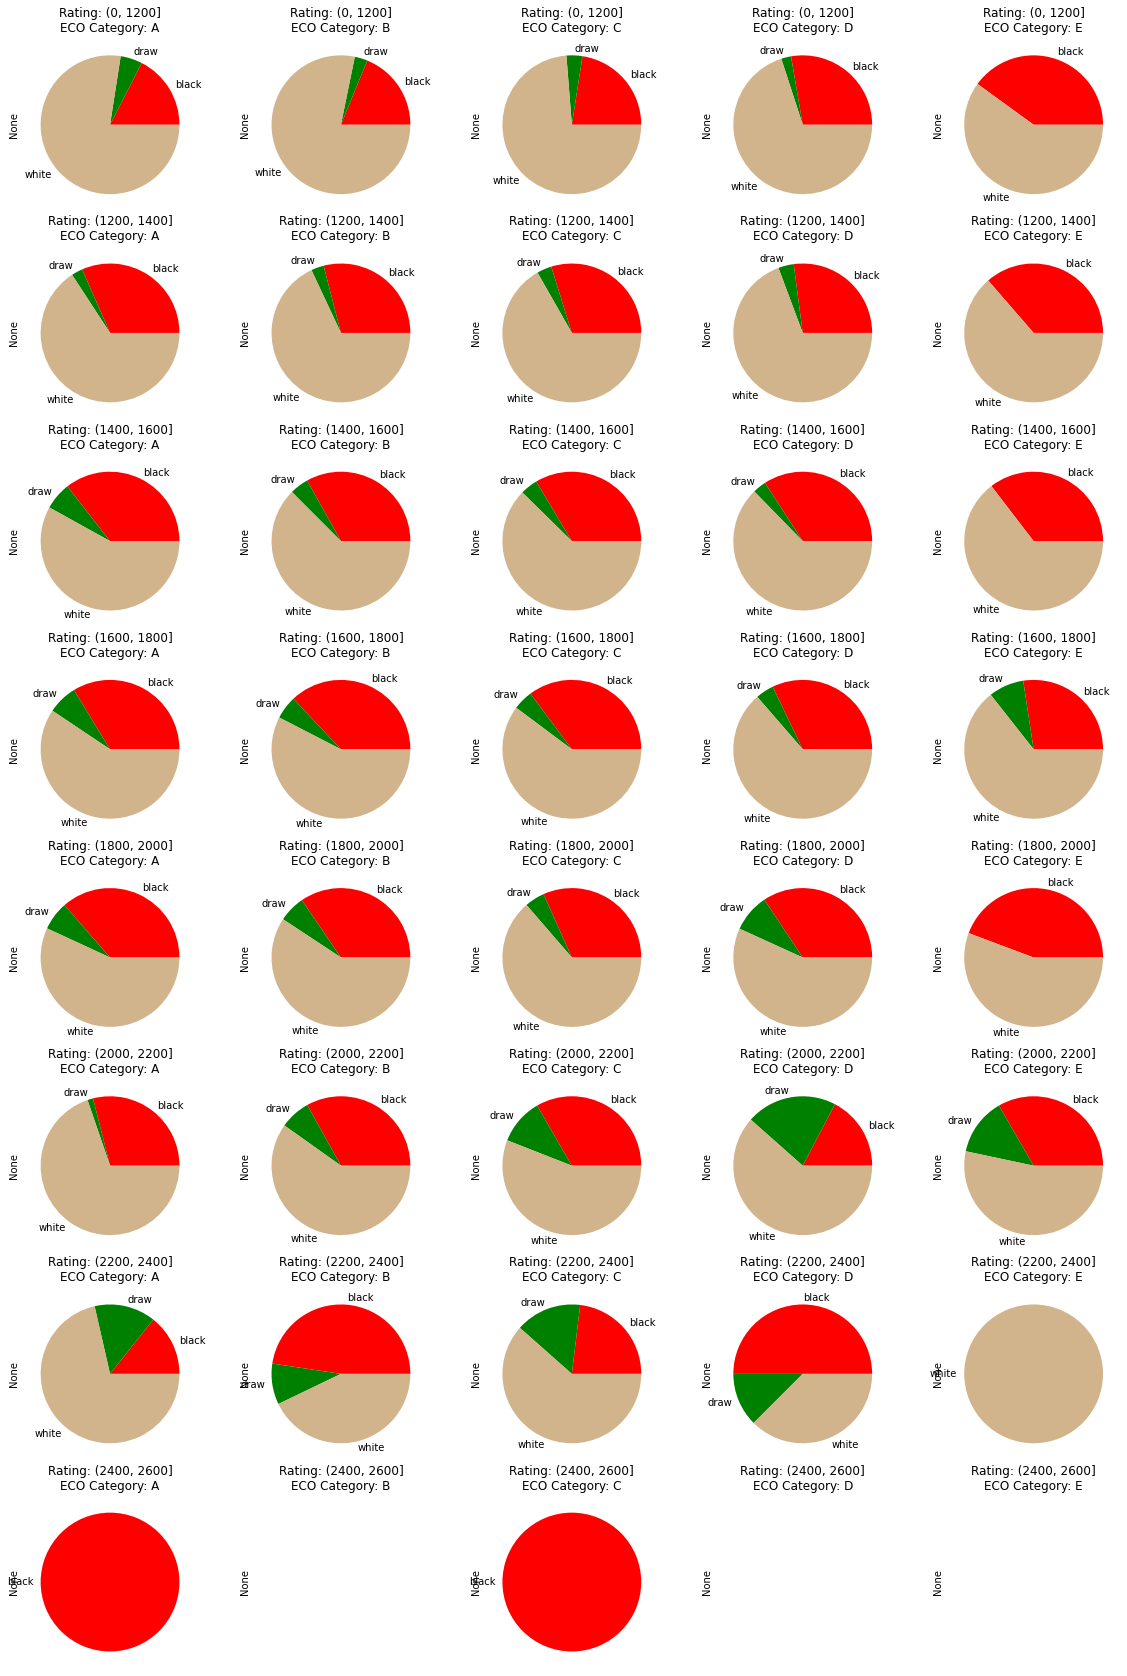

In [11]:
# repeat above work, but with the data binned by ranges of player ratings
bud_by_range = games_df[(games_df["elo_diff"] > 0)].groupby(["black_range", "opening_cat"])["winner"].value_counts().rename("winrate")

## graph to visualize this
bud_by_range.reset_index(level = 2).sort_index()

bud_df = bud_by_range.unstack(level = 0).unstack(level = 0).fillna(0).apply(lambda x : 0 if (x.sum() == 0) else (100 * x / float(x.sum())) ).stack(level = 1).reorder_levels([1,0]).sort_index()
bud_df.stack().reorder_levels([2,0,1]).sort_index()

f, a = plt.subplots(len(bud_df.stack().reorder_levels([2,0,1]).sort_index().index.get_level_values(0).unique()), len(bud_df.stack().reorder_levels([2,0,1]).sort_index().index.get_level_values(1).unique()), figsize = (20,30))
for i, elo_range in enumerate(bud_df.stack().reorder_levels([2,0,1]).sort_index().index.get_level_values(0).unique()):
    for j, eco_cat in enumerate(bud_df.stack().reorder_levels([2,0,1]).sort_index()[elo_range].index.get_level_values(0).unique()):
        
        bud_df.stack().reorder_levels([2,0,1]).sort_index()[elo_range][eco_cat].plot(kind = "pie", ax = a[i][j], colors = ["red", "green", "tan"], title = f'Rating: {elo_range}\nECO Category: {eco_cat}')

plt.savefig("output/Black Underdog-detailed breakdown.png")
plt.show()

In [12]:
pd.DataFrame(bud_df.stack().reorder_levels([2,0,1]).sort_index()).rename(columns = {0 : "percent"}).to_csv("output/black_winrate_by_range_cat.csv")
pd.DataFrame(wud_df.stack().reorder_levels([2,0,1]).sort_index()).rename(columns = {0 : "percent"}).to_csv("output/white_winrate_by_range_cat.csv")

In [13]:

pd.DataFrame(wud_df.stack().reorder_levels([2,0,1]).sort_index()).rename(columns = {0 : "percent"}).style.bar(subset = "percent", align = 'mid', color = ['yellow', 'green'])

In [14]:
pd.DataFrame(bud_df.stack().reorder_levels([2,0,1]).sort_index()).rename(columns = {0 : "percent"}).style
